# Demo Pose Estimation

In [282]:
import importlib
import time

import cv2
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd
import numpy as np


import multi_pose.models
import multi_pose.datasets.coco
import multi_pose.coco_eval
import multi_pose.post_processing
importlib.reload(multi_pose.models)
importlib.reload(multi_pose.coco_eval)
importlib.reload(multi_pose.datasets.coco)
importlib.reload(multi_pose.post_processing)

from multi_pose.models import build_model
from multi_pose.post_processing import decode_pose
from multi_pose.datasets.preprocessing import vgg_preprocess
from multi_pose import im_transform
from multi_pose.coco_eval import get_multiplier, get_outputs, handle_paf_and_heat

### Loading pre-trained symbolic model

In [252]:
ctx = mx.gpu(1)
net = build_model(trunk='resnet18_v1b', pretrained_ctx=[ctx], is_train=False, num_joints=19)
net.load_parameters('model_checkpoints/resnet18_v1brefactor_resnet18_v1b_pose_0.params', ctx=ctx)

In [253]:
SIZE = 384
net.hybridize(static_shape=True, static_alloc=True)

In [254]:
%%time
out, _ = net(mx.nd.ones((1, 3, SIZE, SIZE), dtype='float32', ctx=ctx)) #warm-up
out[0].wait_to_read()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.1 ms


## Detecting pose on sample image

In [325]:
test_image = './images/fam.png'
img = cv2.imread(test_image) # B,G,R order
img = cv2.resize(img, (SIZE,SIZE))

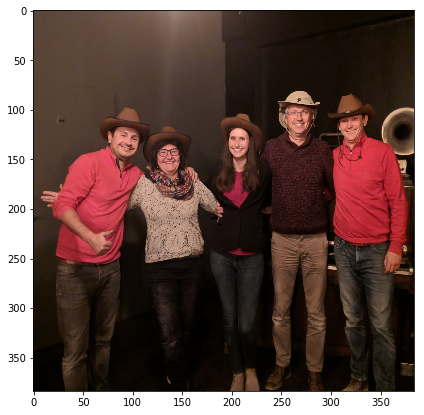

In [326]:
plt.figure(figsize=(7,7))
plt.imshow(img[:,:,::-1])

## Precise Inference

In [327]:
%%time 
# Get results of original image[
multiplier = [0.6, 0.8, 1.0, 1.2]

tic = time.time()
orig_paf, orig_heat = get_outputs(multiplier, img, net,  'vgg', ctx=ctx, downsampling=4)

# Get results of flipped image
swapped_img = img[:, ::-1, :]
flipped_paf, flipped_heat = get_outputs(multiplier, swapped_img, net, 'vgg', ctx=ctx)

# compute averaged heatmap and paf
paf, heatmap = handle_paf_and_heat(orig_heat, flipped_heat, orig_paf, flipped_paf)
            
param = {'thre1': 0.2, 'thre2': 0.1, 'thre3': 0.1}
canvas, to_plot, candidate, subset = decode_pose(img, orig_heat, orig_paf, 0.01, 0.05)

-Get all joints 0.06970667839050293
-Unravel joints 0.00025725364685058594
-Connect limbs 0.08806347846984863
-Connect limbs to people 0.0009171962738037109
-Create pose canvas 0.0036475658416748047
CPU times: user 4.37 s, sys: 2.98 s, total: 7.35 s
Wall time: 910 ms


Results

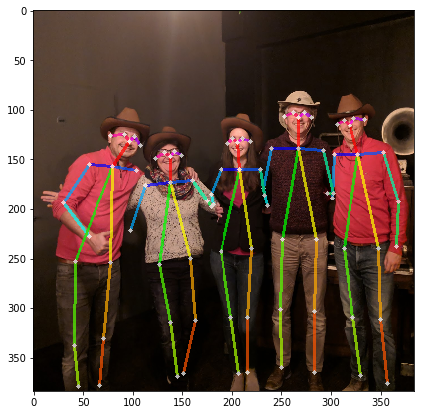

In [328]:
plt.figure(figsize=(7,7))
plt.imshow(to_plot[:,:,::-1])

## Fast inference

In [329]:
transform_im = mx.gluon.data.vision.transforms.Compose(
    [
        mx.gluon.data.vision.transforms.Resize(SIZE, True),
        mx.gluon.data.vision.transforms.CenterCrop(SIZE, cv2.INTER_CUBIC),
    ]
)

In [330]:
transform_tens = mx.gluon.data.vision.transforms.Compose(
    [
        mx.gluon.data.vision.transforms.ToTensor(),
        mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [334]:
%%time
tic = time.time()
img_ = transform_im(mx.image.imread(test_image, to_rgb=False))

img_.wait_to_read()
print("Load image", time.time()-tic)
tic = time.time()
paf, hm = net(transform_tens(img_).expand_dims(axis=0).as_in_context(ctx))
paf.wait_to_read()
hm.wait_to_read()
print("Process image", time.time()-tic)
tic = time.time()
canvas, to_plot, candidate, subset = decode_pose(img_.asnumpy(), hm[0].asnumpy().transpose((1,2,0)), paf[0].asnumpy().transpose((1,2,0)), threshold_path_min_val=-10, minimum_activation=0.05)
print("Process HM and PAF", time.time()-tic)
tic = time.time()

Load image 0.048784494400024414
Process image 0.005533456802368164
-Get all joints 0.018356800079345703
-Unravel joints 0.0004241466522216797
-Connect limbs 0.08838438987731934
-Connect limbs to people 0.001163482666015625
-Create pose canvas 0.005372762680053711
Process HM and PAF 0.11589670181274414
CPU times: user 1.99 s, sys: 1.1 s, total: 3.09 s
Wall time: 171 ms


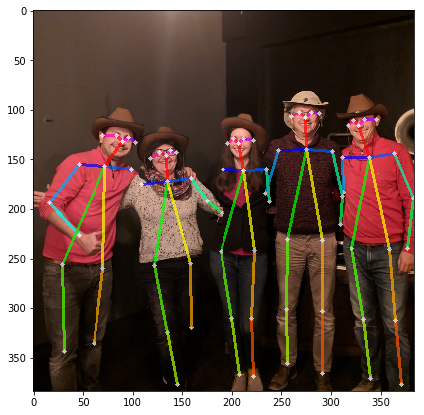

In [335]:
plt.figure(figsize=(7,7))
plt.imshow(to_plot[:,:,::-1])

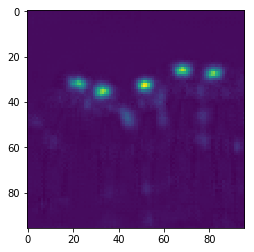

In [333]:
plt.imshow(net(transform(mx.image.imread(test_image)).expand_dims(axis=0).as_in_context(ctx))[1][0].mean(axis=0).asnumpy())